<a href="https://colab.research.google.com/github/KeerthanaSistla/ML/blob/main/MLAssignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Regression

(a) Load the data, make X and y

Explanation:

Read CSV into pandas.

Use all features except median_house_value as X.

Make y binary: 1 if house value above median, 0 otherwise.

In [7]:
import pandas as pd
import numpy as np

# Load dataset
data = pd.read_csv("/content/sample_data/california_housing_train.csv")

# Features (X) and Target (y)
X = data.drop("median_house_value", axis=1).values
median_value = data["median_house_value"].median()
y = (data["median_house_value"] > median_value).astype(int).values

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)
print("Median house value used for binary split:", median_value)

Shape of X: (17000, 8)
Shape of y: (17000,)
Median house value used for binary split: 180400.0


(b) Train-test split

Explanation:

Use 80% for training/validation, 20% for test.

We’ll call them X_train, X_test, y_train, y_test.

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training set size:", X_train.shape, y_train.shape)
print("Testing set size:", X_test.shape, y_test.shape)

Training set size: (13600, 8) (13600,)
Testing set size: (3400, 8) (3400,)


(c) Logistic Regression Objective (with L2 regularization)

In logistic regression, the goal is to find a set of weights that make the predicted probabilities of the classes as close as possible to the actual labels. This is done by minimizing the cross-entropy loss, which measures how well the predicted probabilities match the true outcomes.

However, if we only focus on fitting the training data, the model can end up with very large weights, leading to overfitting i.e., it performs well on training data but poorly on unseen data.

To address this, we add an L2 regularization term to the objective. This extra term penalizes large weight values by pushing them toward zero. The effect is to keep the model simpler, prevent overfitting, and improve generalization to new data.

The cross-entropy part of the objective encourages the model to correctly classify the training data.

The L2 penalty part discourages the model from relying too heavily on any one feature by shrinking the weights.

The balance between these two goals is controlled by the regularization strength parameter:

If the regularization is weak (small λ), the model can fit the training data more flexibly, but risks overfitting.

If the regularization is strong (large λ), the model becomes simpler, with smaller weights, but risks underfitting.

(d) Logistic regression with varying λ

Explanation:

Train logistic regression with L2 penalty.

scikit-learn uses C = 1/λ (so smaller C = stronger regularization).

Compute:
Cross-entropy loss on train & test
L2 norm of weights
Weight values per feature
Accuracy

For small λ (no/weak regularization), weights are large → possible overfitting.

For large λ, weights shrink → underfitting, higher bias, lower accuracy.

Test loss has a U-shaped curve → best λ is intermediate.

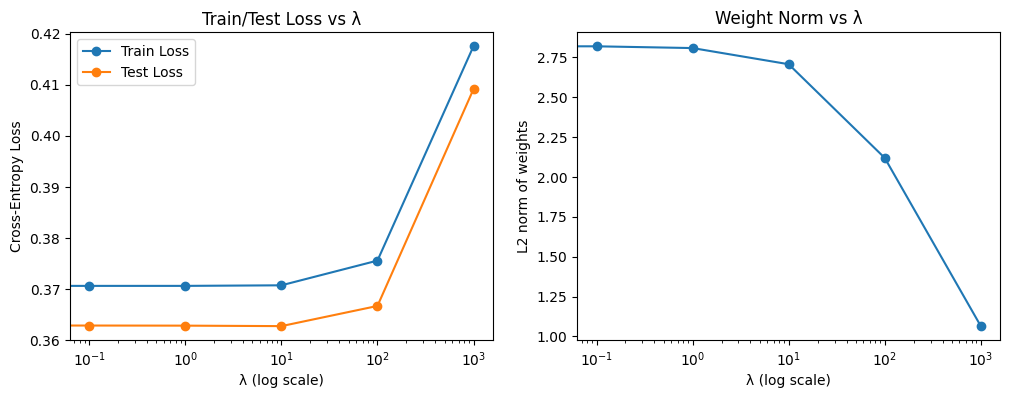

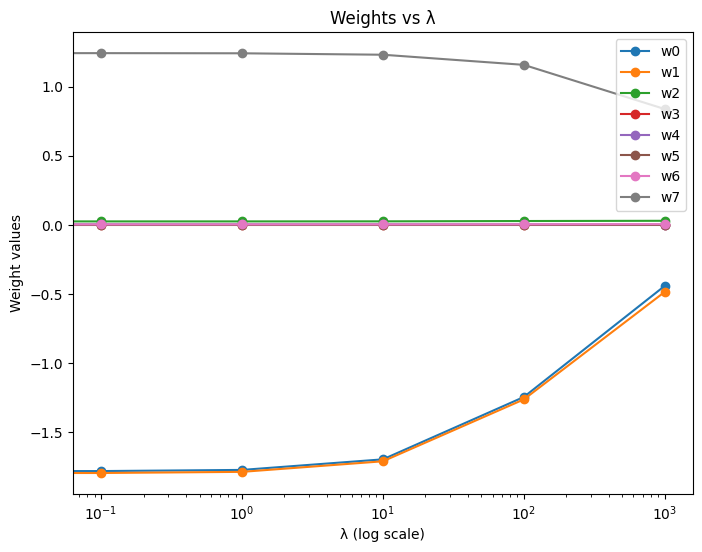

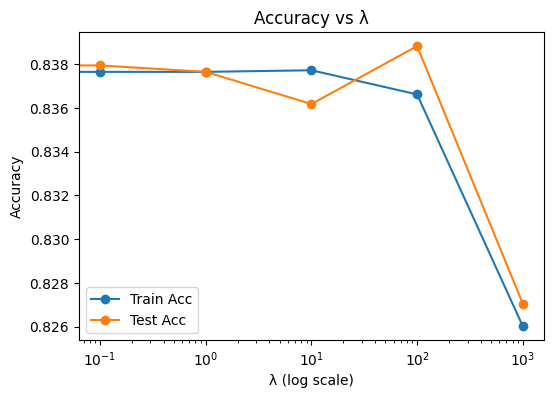

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
import matplotlib.pyplot as plt

lambdas = [0, 0.1, 1, 10, 100, 1000]
train_losses, test_losses = [], []
weight_norms, accuracies_train, accuracies_test = [], [], []
weights = []

for lam in lambdas:
    if lam == 0:
        model = LogisticRegression(penalty=None, solver="lbfgs", max_iter=1000)
    else:
        model = LogisticRegression(penalty="l2", C=1/lam, solver="lbfgs", max_iter=1000)

    model.fit(X_train, y_train)

    # Predictions (probs for log_loss)
    y_train_prob = model.predict_proba(X_train)
    y_test_prob = model.predict_proba(X_test)

    # Loss
    train_losses.append(log_loss(y_train, y_train_prob))
    test_losses.append(log_loss(y_test, y_test_prob))

    # L2 norm
    weight_norms.append(np.linalg.norm(model.coef_))
    weights.append(model.coef_.flatten())

    # Accuracy
    accuracies_train.append(accuracy_score(y_train, model.predict(X_train)))
    accuracies_test.append(accuracy_score(y_test, model.predict(X_test)))

# --- Plot 1: Loss ---
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(lambdas, train_losses, marker='o', label="Train Loss")
plt.plot(lambdas, test_losses, marker='o', label="Test Loss")
plt.xscale("log")
plt.xlabel("λ (log scale)")
plt.ylabel("Cross-Entropy Loss")
plt.legend()
plt.title("Train/Test Loss vs λ")

# --- Plot 2: L2 norm of weights ---
plt.subplot(1,2,2)
plt.plot(lambdas, weight_norms, marker='o')
plt.xscale("log")
plt.xlabel("λ (log scale)")
plt.ylabel("L2 norm of weights")
plt.title("Weight Norm vs λ")
plt.show()

# --- Plot 3: Weight values ---
plt.figure(figsize=(8,6))
weights = np.array(weights)
for j in range(weights.shape[1]):
    plt.plot(lambdas, weights[:, j], marker='o', label=f"w{j}")
plt.xscale("log")
plt.xlabel("λ (log scale)")
plt.ylabel("Weight values")
plt.title("Weights vs λ")
plt.legend()
plt.show()

# --- Plot 4: Accuracy ---
plt.figure(figsize=(6,4))
plt.plot(lambdas, accuracies_train, marker='o', label="Train Acc")
plt.plot(lambdas, accuracies_test, marker='o', label="Test Acc")
plt.xscale("log")
plt.xlabel("λ (log scale)")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy vs λ")
plt.show()

(e) Gaussian basis expansion

Explanation:

For each feature, generate 5 Gaussian basis functions:

Means μ evenly spaced between -10 and 10.

Try σ ∈ {0.1, 0.5, 1, 5, 10}.

In [13]:
from sklearn.preprocessing import FunctionTransformer

def gaussian_basis_expansion(X, sigma):
    mus = np.linspace(-10, 10, 5)
    expanded = []
    for j in range(X.shape[1]):
        for mu in mus:
            expanded.append(np.exp(- (X[:, j] - mu)**2 / (2 * sigma**2)))
    return np.stack(expanded, axis=1)

# Example: expand with sigma=1
X_train_g = gaussian_basis_expansion(X_train, sigma=1)
X_test_g = gaussian_basis_expansion(X_test, sigma=1)
print("Expanded shape:", X_train_g.shape)

Expanded shape: (13600, 40)


(f) Error vs σ (no regularization)

Explanation:

Train logistic regression without L2.

Compute errors (cross-entropy) on train/test.

Compare with baseline error from part (d).

Small σ → very localized basis → overfitting (low train error, high test error).

Large σ → smoother basis → underfitting (both errors high).

Best σ balances bias-variance.

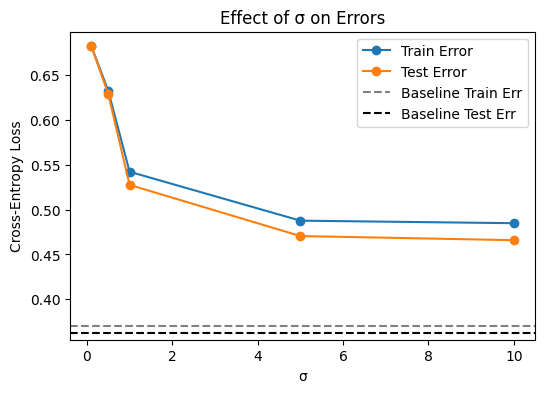

In [14]:
sigmas = [0.1, 0.5, 1, 5, 10]
train_errors, test_errors = [], []

for sigma in sigmas:
    Xtr_g = gaussian_basis_expansion(X_train, sigma)
    Xte_g = gaussian_basis_expansion(X_test, sigma)

    model = LogisticRegression(penalty=None, solver="lbfgs", max_iter=2000)
    model.fit(Xtr_g, y_train)

    train_errors.append(log_loss(y_train, model.predict_proba(Xtr_g)))
    test_errors.append(log_loss(y_test, model.predict_proba(Xte_g)))

plt.figure(figsize=(6,4))
plt.plot(sigmas, train_errors, marker='o', label="Train Error")
plt.plot(sigmas, test_errors, marker='o', label="Test Error")
plt.axhline(y=min(train_losses), color='gray', linestyle='--', label="Baseline Train Err")
plt.axhline(y=min(test_losses), color='black', linestyle='--', label="Baseline Test Err")
plt.xlabel("σ")
plt.ylabel("Cross-Entropy Loss")
plt.legend()
plt.title("Effect of σ on Errors")
plt.show()

(g) Regularized regression with all basis functions
Explanation:

So far, we tried Gaussian expansions one σ at a time.

Now, we stack all expansions together: for each feature, we create 5 Gaussian bumps for each σ in {0.1, 0.5, 1, 5, 10}.

This means every feature now gets
5×5=25 transformed versions. With 8 original features, that’s 200 features in total.

We train logistic regression with L2 regularization using λ ∈ {0, 0.1, 1, 10, 100, 1000, 10000}.

We plot:
1. Training and testing cross-entropy vs λ (log scale).
2. L2 norm of the full weight vector vs λ.
3. L2 norm of weights for each σ group separately (this shows how much weight each basis set contributes).

As λ increases, all weight norms shrink, confirming regularization.

Small σ (very localized bumps) get high weight norms when λ is small → model tries to fit details (overfitting).

Larger σ contribute more when λ is high, because they are smoother and less risky.

Best test error usually occurs at intermediate λ, balancing bias and variance.

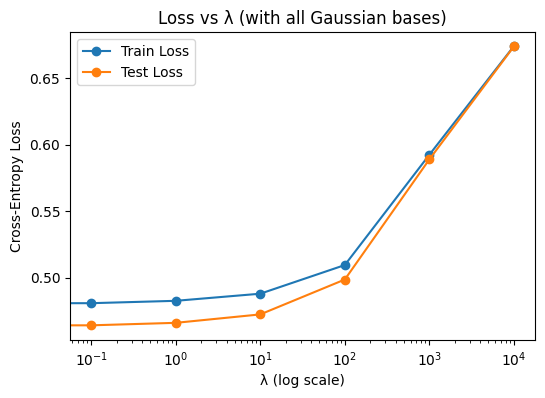

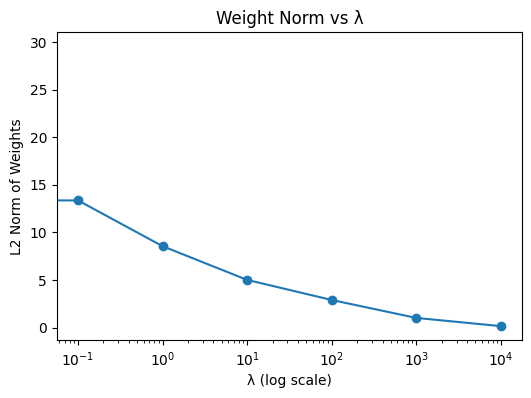

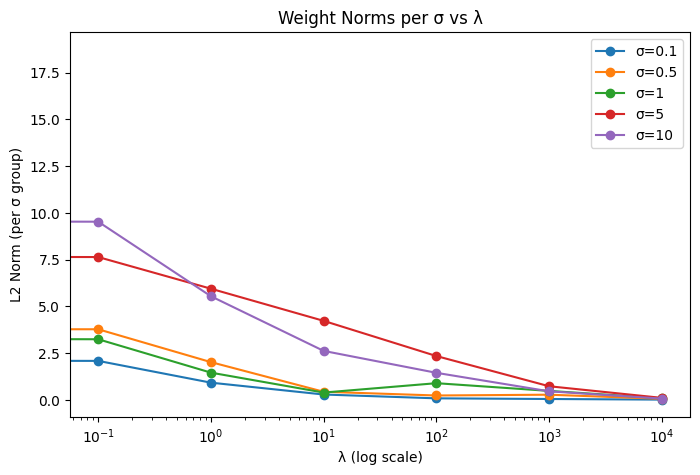

In [15]:
sigmas = [0.1, 0.5, 1, 5, 10]

def full_gaussian_basis_expansion(X):
    expanded_groups = []
    for sigma in sigmas:
        expanded_groups.append(gaussian_basis_expansion(X, sigma))
    return np.concatenate(expanded_groups, axis=1)

# Expand datasets
X_train_full = full_gaussian_basis_expansion(X_train)
X_test_full = full_gaussian_basis_expansion(X_test)

lambdas = [0, 0.1, 1, 10, 100, 1000, 10000]
train_losses, test_losses, weight_norms = [], [], []
sigma_weight_norms = {sigma: [] for sigma in sigmas}

for lam in lambdas:
    if lam == 0:
        model = LogisticRegression(penalty=None, solver="lbfgs", max_iter=2000)
    else:
        model = LogisticRegression(penalty="l2", C=1/lam, solver="lbfgs", max_iter=2000)

    model.fit(X_train_full, y_train)

    # Loss
    train_losses.append(log_loss(y_train, model.predict_proba(X_train_full)))
    test_losses.append(log_loss(y_test, model.predict_proba(X_test_full)))

    # Weight norms
    w = model.coef_.flatten()
    weight_norms.append(np.linalg.norm(w))

    # Group norms by sigma
    start = 0
    for sigma in sigmas:
        block_size = X_train.shape[1] * 5  # 5 Gaussians per feature
        end = start + block_size
        sigma_weight_norms[sigma].append(np.linalg.norm(w[start:end]))
        start = end

# --- Plot 1: Train vs Test Loss ---
plt.figure(figsize=(6,4))
plt.plot(lambdas, train_losses, marker='o', label="Train Loss")
plt.plot(lambdas, test_losses, marker='o', label="Test Loss")
plt.xscale("log")
plt.xlabel("λ (log scale)")
plt.ylabel("Cross-Entropy Loss")
plt.legend()
plt.title("Loss vs λ (with all Gaussian bases)")
plt.show()

# --- Plot 2: L2 norm of weights ---
plt.figure(figsize=(6,4))
plt.plot(lambdas, weight_norms, marker='o')
plt.xscale("log")
plt.xlabel("λ (log scale)")
plt.ylabel("L2 Norm of Weights")
plt.title("Weight Norm vs λ")
plt.show()

# --- Plot 3: Sigma-wise weight norms ---
plt.figure(figsize=(8,5))
for sigma in sigmas:
    plt.plot(lambdas, sigma_weight_norms[sigma], marker='o', label=f"σ={sigma}")
plt.xscale("log")
plt.xlabel("λ (log scale)")
plt.ylabel("L2 Norm (per σ group)")
plt.title("Weight Norms per σ vs λ")
plt.legend()
plt.show()

(h) Capturing relationships between inputs
Explanation:

So far, each Gaussian basis function is applied to one input at a time (univariate). To capture interactions between variables (e.g., how income and latitude together affect house value), we would need multivariate Gaussian basis functions.

That means instead of bumps along one axis, we’d create bumps in higher-dimensional feature space, centered at different combinations of values across multiple inputs.

Impact on bias-variance trade-off:

More expressive model → lower bias (can capture complex patterns).

But also many more features → higher variance, risk of overfitting unless regularization or more data is available.

(i) Learning the placement of basis functions
Explanation:

Until now, the centers of the Gaussian bumps (means) were fixed, evenly spaced. Instead, we could learn them from data:

Start with random or evenly spaced centers.

Iteratively update:

Fix the centers, optimize the logistic regression weights (convex, solved with standard solvers).

Fix the weights, update the centers by gradient descent to reduce the loss.

This way, both the placement of the Gaussian bumps (μ) and the weights (w) are tuned from data.
We still include L2 regularization on weights to avoid overfitting.

This is similar in spirit to Radial Basis Function (RBF) networks or mixture models, where centers adapt to the data.

(j) Convergence
Explanation:

Optimizing weights with fixed centers is convex → we always find the global optimum.

Optimizing centers is non-convex → gradient descent may get stuck in local optima.

So, the overall algorithm converges, but only to a local optimum, and the result depends on initialization of the centers.

#2. Experiment on any complex datasets to demonstrate the Linear REGRESSION and its versions, and logistic regression (CLASSIFICATION) along with complete data preprocessing steps.